# Install packages 

- mecab
- konlpy


ref: https://dacon.io/en/codeshare/2884

In [ ]:
# install packages (ref: https://dacon.io/en/codeshare/2884)
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:1

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading 

In [ ]:
# import packages
import numpy as np
import pandas as pd
from glob import glob
import tqdm
import matplotlib.pyplot as plt

import konlpy
from konlpy.tag import Okt, Mecab
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1. Import & concat abstracts


In [ ]:
file_list = []
fpath_list = glob('./Abstracts/*')
for fpath in sorted(fpath_list):
  tmp_file = pd.read_excel(fpath)
  # print(fpath.split('/')[-1].replace('.xlsx', ''), tmp_file.shape)
  file_list.append(tmp_file)
abstr_all = pd.concat(file_list, axis=0, ignore_index=True)
abstr_all['course_id'] = abstr_all['course_id'].apply(lambda x: x.split()[0])

In [ ]:
# # check if any missing crawling conditions

# def check_missing_cond(in_df, iterables, names, keycol):
#   all_combs = pd.DataFrame(index=pd.MultiIndex.from_product(iterables, names = names))
#   check_df = all_combs.merge(in_df, left_index=True, right_on=names, how='left')
#   return check_df.loc[check_df[keycol].isna(), names]

# query_keyword_list = ['AI', '딥러닝', '머신러닝', '통계', '시각화', '영상처리', '인과추론', '자연어처리', '강화학습', '데이터']
# year_list = [2020, 2021, 2022]
# semester_list = ['1학기', '2학기']

# check_missing_cond(abstr_all, [query_keyword_list, year_list, semester_list], ['query_keyword', 'year', 'semester'], 'course_id')

# # [검색 결과 없음으로 미 업데이트]
# # 강화학습 2020 2학기
# # 영상처리 2020 2학기
# # 인과추론 2020 2학기

In [ ]:
# delete redundant courses

print(f"max # same course_id occurs: {abstr_all.groupby('course_id').size().max()}")
# ---- possible reason 1) courses offerred over many semesters
# ---- possible reason 2) courses have multiple openings per semester (course_id 001, 002, ...)
# ---- possible reason 3) courses searched by multiple keywords
# --> handling. just drop duplicates by course_id
#               because same course_id has same abstract
print(f"# unique abstract (kor) per course_id: {abstr_all.groupby('course_id')['abstract'].apply(lambda x: len(set(x))).sort_values(ascending=False).max()}")
# if want to keep the latest abstract
# abstr = abstr_all.sort_values(by=['year', 'semester'], ascending=True).drop_duplicates(subset=['course_id'], keep='last')
abstr = abstr_all.drop_duplicates(subset=['course_id']).reset_index(drop=True)

max # same course_id occurs: 120
# unique abstract (kor) per course_id: 1


In [ ]:
# # courses with null abstract -> drop them from analysis
# print(f"# courses with null abstract : {abstr.loc[abstr['abstract'].isna()].shape[0]}")
# display(abstr.loc[abstr['abstract'].isna()])

# abstr = abstr.loc[~abstr['abstract'].isna(),:].copy()
# display(abstr.loc[abstr['abstract'].isna()])

In [ ]:
# # handle when course_abstract is shared by many course_id

# # -- case 2. when abstract repeats even after removing redundant course_id
# # ---- possible reason 1) when the same course is re-registered with a new id and name
# # there's duplicate courses with the same abstract
# print(f"# unique course_id per same abstract (kor): {abstr.groupby('abstract')['course_id'].apply(lambda x: len(set(x))).sort_values(ascending=False).max()}")

# # 최신 개강된 강의만 남기고 drop?
# abstr = abstr.sort_values(by=['year', 'semester'], ascending=True).drop_duplicates(subset=['abstract'], keep='last')

# print(f"# unique course_id per same abstract (kor): {abstr.groupby('abstract')['course_id'].apply(lambda x: len(set(x))).sort_values(ascending=False).max()}")

In [ ]:
abstr = abstr.drop(columns=['year', 'semester', 'query_keyword'])

In [ ]:
print(abstr.shape)
display(abstr)

(1938, 4)


,course_id,course_name,abstract_kor,abstract_eng
0,M2183.001200,음악과 AI,4차 산업혁명이라 불리는 인공지능시대를 맞아 음악대학에서는 학생들이 시대적 변화에 ...,"In the era of AI, the College of Music wants t..."
1,M2194.002800,데이터와 인공지능법,머신러닝 등 빅데이터를 활용한 인공지능 기술의 급속한 발전 및 사회 각 분야로의 파...,With the advancements of data dependant artifi...
2,M2177.004900,IoT·인공지능·빅데이터 개론 및 실습,본 강좌는 학부 3학년 교과목으로 전기·정보공학 및 컴퓨터공학 비전공자를 대상으로 ...,This course is for junior-level undergraduate ...
3,654.592,전공실기(국악기악),"대학원 과목이다. 국악과의 석사과정 기악 및 성악, 작곡전공 학생들이 넷째 학기를 ...",This course is for graduate students (except m...
4,353.726A,패션리테일링특론,상품유통에 대한 최근의 이론과 연구결과를 살펴보고 의류상품에서 특별하게 나타나는 유...,상품유통에 대한 최근의 이론과 연구결과를 살펴보고 의류상품에서 특별하게 나타나는 유...
...,...,...,...,...
1933,430.523,확률신호론,확률제어와 추정론 및 진보된 현대제어 이론의 기초가 되는 Stochastic Pro...,This course examines linear stochastic process...
1934,205.730A,사회학이론구성세미나,"본 강좌에서는 사회학적 연구가 기초한 다양한 설명의 논리들에 대해 검토한 후, 기존...",Students are required to review diverse logics...
1935,5321.5604,실험디자인과 논문작성,바이오모듈레이션 전공 대학원생이 현재 수행하고 있는 연구 및 이를 기초로 한 학위논...,This course is to conduct seminars on thesis d...
1936,5321.5404,곤충생태학 및 실험,"이 교과목에서는 곤충생태학의 주요 개념들을 배운다. 예를 들어, 생태계 개념, 곤충...","In this course, students will learn the major ..."


In [ ]:
abstr['abstract'].fillna('', inplace=True)
abstr['abstract_eng'].fillna('', inplace=True)
abstr = abstr.reset_index(drop=True)
abstr = abstr.rename(columns={'course_id': 'cid', 'abstract': 'abstract'})

In [ ]:
# abstr['abstract'].apply(len).max()

996

## Ingest to Postgre db for backup

In [ ]:
# # db 적재
# !pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 5.4 MB/s 


In [ ]:
import psycopg2
import psycopg2.extras as extras

# 연결정보 입력
connection_info = "host=<host> dbname=<db-name> user=<user> password=<passwd> port=<port>"

# PostgreSQL 연결
# conn = psycopg2.connect(connection_info)

In [ ]:
def execute_transaction(conn, query):

  try:
      cursor = conn.cursor()
      cursor.execute(query)
      conn.commit()

  except Exception as e:
      print("Error: ", e)
      conn.rollback()
      
  finally:
      conn.close()

def select_from(conn, query):

  try:
      df = pd.read_sql(query,conn)

  except Exception as e:
      df = pd.DataFrame()
      print("Error: ", e)
      
  finally:
      conn.close()
      return df

def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    Source: https://naysan.ca/2020/05/09/pandas-to-postgresql-using-psycopg2-bulk-insert-performance-benchmark/
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()

# conn = psycopg2.connect(connection_info)
# query1 = "CREATE TABLE rec_abstracts(cid varchar(255), abstract varchar(2000));"
# execute_transaction(conn, query1)

In [ ]:
# conn = psycopg2.connect(connection_info)
# execute_values(conn, abstr[['cid', 'abstract']], "rec_abstracts")

execute_values() done


In [ ]:
conn = psycopg2.connect(connection_info)
query2 = "SELECT a.cid, a.cname, b.abstract FROM check_course a NATURAL JOIN rec_abstracts b;"
select_from(conn, query2)

,cid,cname,abstract
0,031.032,창의적 사고와 표현,오늘날 대학교육에서 가장 절실하게 요구되는 것들 중 하나는 창의성 교육이다. 본 교...
1,032.005,초급한문 1,본 교과목은 한자와 한문에 대해 거의 모르는 초보자를 위한 강좌로 한문에 대한 기초...
2,032.014,중국어회화 1,본 교과목은 중급중국어1 이상의 수준을 갖추고 있는 학생을 대상으로 회화에 중점을 ...
3,032.015,중국어회화 2,본 교과목은 중국어회화1 이상의 수준을 갖춘 학생을 대상으로 유창하고 우아한 소통에...
4,032.017,대학영어 1,"본 강좌의 목적은 말하기, 듣기, 읽기, 쓰기의 영역을 모두 다룸으로써 학생들의 영..."
...,...,...,...
1933,M3239.005800,데이터사이언스를 위한 수학과 통계의 기초,데이터 과학의 모든 영역은 데이터 수집 및 분석과 관련이 있다. 본 과목은 데이터사...
1934,M3239.005900,앰비언트 인공지능 플랫폼 및 실습,"기존의 클라우드 의존적 AI 컴퓨팅이 사용자 프라이버시, 네트워크 과부하, 인터넷 ..."
1935,M3239.006500,머신러닝을 위한 연속형 수리적 방법,이 과목에서는 머신러닝과 딥러닝을 포함하는 컴퓨터과학 전반을 공부하는데 필요한 수리...
1936,M3239.006700,데이터사이언스 프로젝트,이 과정은 프로젝트 중심 수업으로 학생들은 end-to-end 프로젝트를 통해 데이...


# 2. Preprocessing (tokenizing + vectorizing)

ref: http://doc.mindscale.kr/km/unstructured/03.html  
mecab 품사설명: http://openuiz.blogspot.com/2016/07/mecab-ko-dic.html

## 2-1. Tokenizing (using mecab)

In [ ]:
# 구현하고 싶은 기능들
# stop words를 제거한다.
# 특정 단어를 합친다. -> 사용자 사전을 쓰는게 정석이다. -> 일단 사용자 사전 없이 되게 구현함 # -> bigram을 쓰는 방법?
# 특정 단어를 유의어로 바꾼다. -> 사용자 사전을 쓰는게 정석이다. -> 일단 사용자 사전 없이 되게 구현함

class NLProcessor():
  def __init__(self, tagger, stopwords=None, synonyms=None, composites=None):
    self.tagger = tagger
    self.stopwords = stopwords
    self.synonyms = synonyms
    self.composites = composites # assumption: 2 words
    self.wordcount = Counter()

  def get_nouns_and_sl(self, text):
    pos = self.tagger.pos(text)
    nouns = [x[0] for x in pos if x[1].startswith('N') or x[1] == 'SL'] # nouns and SL (foreign words)
    nouns = [x.lower() for x in nouns] # lowercase for SL (english, etc.) words
    # merge two consecutive tokens into one token if in composites
    if self.composites is not None:
      for i in range(len(nouns)-1):
        if tuple(nouns[i:i+2]) in self.composites:
          repl = self.composites[tuple(nouns[i:i+2])]
          nouns = nouns[:i] + nouns[i+2:] 
          nouns.insert(i, repl)
    # replace tokens with synonyms
    if self.synonyms is not None:
      nouns = [self.synonyms[x] if x in self.synonyms.keys() else x for x in nouns]
    # remove stopwords
    if self.stopwords is not None:
      nouns = [x for x in nouns if x not in self.stopwords]
    nouns = [x for x in nouns if len(x) > 1]
    return nouns

  def update_stopwords(self, stopwords):
    if self.stopwords is None:
      self.stopwords = stopwords
    else:  
      self.stopwords = list(set(self.stopwords + stopwords))

  def update_wordcount(self, nouns_list):
    for nouns in nouns_list:
        self.wordcount.update(nouns)

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list += "과목 학습 분야 집중 때문 강좌 목표 학생 배양 중요 요구 대학 \
역량 개설 수업 주요 내용 다양 최근 능력 마련 \
등장 자신 교과목 목적 최대한 강의 강좌 이해 시도 수강 한편 강조 관련 우리".split(" ")
composites_dict = {('머신', '러닝'): '머신러닝', 
                   ('machine', 'learning'): 'machine learning', 
                   ('artificial', 'intelligence'): 'ai',
                   ('neural', 'network'): 'neural network',
                   ('neural', 'networks'): 'neural network',
                   ('internet', 'things'): 'iot',
                   ('기계', '학습'): '기계학습',
                   ('데이터', '사이언스'): '데이터사이언스',
                   ('data', 'science'): 'data science',
                   ('빅', '데이터'): '빅데이터',
                   ('big', 'data'): 'big data',
                   ('컴퓨터', '비전'): '컴퓨터비전',
                   ('컴퓨터', '비젼'): '컴퓨터비젼',
                   ('computer', 'vision'): 'computer vision',
                   ('인과', '추론'): '인과추론',
                   ('강화', '학습'): '강화학습',
                   ('이상', '탐지'): '이상탐지',
                   ('anomaly', 'detection'): 'anomaly detection',
                   ('reinforcement', 'learning'): 'reinforcement learning',
                   ('causal', 'inference'): 'causal inference'}
synonyms_dict = {'ai': '인공지능', 
                 'accountability': '책임', 
                 'data': '데이터', 
                 'machine learning': '머신러닝',
                 'optimization': '최적화',
                 'computer': '컴퓨터',
                 'autoencoderes': 'autoencoder',
                 'autoencoders': 'autoencoder',
                 'perceptron': 'neural network',
                 'probability': '확률',
                 'data science': '데이터사이언스',
                 'computer vision': '컴퓨터비전',
                 '파이썬': 'python',
                 '기계학습': '머신러닝',
                 '베이즈': '베이지안', 
                 'big data': '빅데이터',
                 'causal inference': '인과추론',
                 'reinforcement learning': '강화학습',
                 'anomaly detection': '이상감지',
                 'technology': '기술'}

processor = NLProcessor(Mecab(), 
                        stopwords = stopwords_list, 
                        synonyms = synonyms_dict, 
                        composites = composites_dict)

# extract nouns and eda
abstr['nouns'] = abstr['abstract'].apply(processor.get_nouns_and_sl)
processor.update_wordcount(abstr['nouns'])


# code to check synonym and composites logic
# processor2 = NLProcessor(Mecab(), 
#                         stopwords = stopwords_list)
# abstr['nouns2'] = abstr['abstract'].apply(processor2.get_nouns_and_sl)
# processor2.update_wordcount(abstr['nouns2'])
# processor2.wordcount['machine'] # 머신 57 #러닝 106 #머신러닝 0 #machine 15 # learning 37
# processor.wordcount['learning'] #머신 7 #러닝 56 #머신러닝 59 #machine 6 #learning 28

In [ ]:
# # code to check original texts containing a word in its nouns list
# word = '확률'
# for _, tmp_df in abstr.loc[abstr['nouns'].apply(lambda x: word in x),:].iterrows():
#   print(tmp_df['course_name'], " ",  tmp_df['abstract'])

In [ ]:
def check_processing_result(text_list, result_list):
  idx = np.random.randint(len(abstr))
  print(text_list[idx])
  print(set(result_list[idx]))

check_processing_result(abstr['abstract'], abstr['nouns'])

이 교과목은 소그룹의 학생이 교수와 함께 고전원전을 읽음으로써 인문학의 기초인 고전에 대한 관심과 이해를 높이고 외국어(고전어 포함) 및 한문 독해능력을 향상시키는 데 그 목적이 있음. 이 교과목은 2005년 7월부터 2009년 6월까지 4년간 인문대학이 시행하는 특성화 교육프로그램의 일환인 창의성 개발 소단위 교육 프로그램의 일환으로 신설되었음. 소단위 교육 프로그램은 다양한 관심과 문제의식을 가진 학생들을 대상으로 밀착교육과 심층학습의 기회를 제공하자는 것이며 이러한 취지에 따라 이 교과목은 가급적 1-5명 정도 소단위 학생을 대상으로 교수연구실에서 운영하고자함. 교수가 선정한 고전 원전 중 학생이 독해 희망 도서를 선택하여 수강 신청 하도록 함. 수강생들의 수준을 고려한 효과적인 지도를 위해 해당 원전 해독능력 중급이하 수준의 학생들을 대상으로 함.
{'시행', '창의', '그룹', '지도', '심층', '교육', '문제', '희망', '취지', '신청', '신설', '한문', '고전어', '포함', '운영', '외국어', '해당', '중급', '밀착', '대상', '선정', '고려', '정도', '프로그램', '개발', '일환', '인문', '연구실', '교수', '독해', '기초', '관심', '도서', '의식', '기회', '고전', '제공', '수준', '원전', '특성', '향상', '해독', '소단위', '선택', '효과', '인문학'}


In [ ]:
print(f"Total # of unique tokens: {len(processor.wordcount.keys())}")

Total # of unique tokens: 7154


## 2-2. Vectorization (using Tf-idf)

(0.0, 9.0)

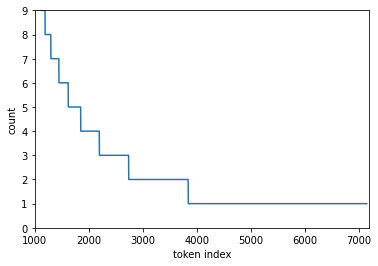

In [ ]:
# plot distribution of counts to find how many tokens to use for vectorizing

plt.plot(sorted(processor.wordcount.values(), reverse=True))
plt.xlabel('token index')
plt.ylabel('count')
plt.xlim([1000,7200])
plt.ylim([0, 9])

In [ ]:
print(f"# of unique tokens with at least 4 counts: {len(dict(filter(lambda x: x[1] >= 4, processor.wordcount.items())))}")

# of unique tokens with at least 4 counts: 2199


In [ ]:
## 2200 max_features to include tokens that occurred at least 4 times (e.g. iot) -> iot 가 딱 4번 나와서 iot도 포함하자.. 이런 로직으로..
cv = CountVectorizer(max_features=2200, tokenizer=processor.get_nouns_and_sl)
tdm = cv.fit_transform(abstr['abstract'])

tfidf = TfidfTransformer()
tdm2 = tfidf.fit_transform(tdm)

words = cv.get_feature_names_out()

In [ ]:
# # helper 함수들
# def print_tfidf(in_tdm):
#   for i, n in sorted(zip(in_tdm.indices, in_tdm.data), key=lambda x: x[1], reverse=True):
#     print(words[i], n)

# def print_tfidf_course(name, metadata, col='course_name'):
#   global tdm2
#   metadata = metadata.reset_index(drop=True)
#   idx = metadata.loc[metadata[col] == name].index[0]
#   print_tfidf(tdm2[idx])

In [ ]:
# 벡터라이저 등 저장
import joblib
joblib.dump(tfidf, 'tfidf_transformer_tok2200.pkl')
joblib.dump(cv, 'count_vectorizer_tok2200.pkl')
joblib.dump(tdm, 'count_tdm.pkl')
joblib.dump(tdm2, 'tfidf_tdm.pkl')
joblib.dump(abstr['cid'].values, 'cid_list.pkl')

['cid_list.pkl']

# 3. Recommendation prototyping 

## 3-1. Content-filtering -> 실제 사용할 시나리오

유저가 들은 과목의 벡터의 평균과 가장 유사한 과목을 추천

In [ ]:
grades = pd.read_excel('2020_27890.xlsx')

In [ ]:
courses = list(grades.iloc[3:, 3].unique())
courses.remove('소계')
courses.remove('교과목번호')
courses.remove(np.nan)

In [ ]:
courses

['M3239.000200',
 'M3239.000900',
 'M3239.000300',
 'M3224.000100',
 'M3239.002000',
 'M3239.001100',
 'M3239.000100',
 'M3239.001000',
 'M3239.004100']

In [ ]:
def get_tfidf_recommendations_custom(courses, meta_data, k=10):
    global tdm2

    tfidf_list = []

    for cid in courses:
      try: 
        idx = list(abstr['cid']).index(cid)
        tfidf_list.append(tdm2[idx,:].toarray())
      except:
        print(f"{cid} not in list")

    mean_tfidf = np.mean(np.stack(tfidf_list), axis=0)

    cosine_sim_custom = cosine_similarity(mean_tfidf, tdm2)

    sim_scores = list(enumerate(cosine_sim_custom[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    rec_indices = [i[0] for i in sim_scores]
    return meta_data.loc[rec_indices, ["cid", "course_name", "abstract"]].loc[~meta_data['cid'].isin(courses)]

In [ ]:
get_tfidf_recommendations_custom(courses, abstr)

M3239.002000 not in list


,cid,course_name,abstract
1599,M3500.000300,(공유)빅데이터 개론 1,빅데이터는 실세계에서 일어나는 복잡한 문제를 해결하기 위한 통찰력을 제공한다. 이 ...
1370,406.561,데이터기반학습,"기계학습은 다양한 분야에서 점차 큰 관심을 받고 있으나, 막상 실제 데이터에 적용하..."
1491,M1522.003900,인공지능 및 빅데이터시스템,본 과목에서는 다양한 인공 지능 (특히 머신 러닝) 및 빅데이터 분석 시스템에 대해...
1421,M2608.001300,기계학습 기초 및 전기정보 응용,본 강좌는 전기정보공학부 및 관련 분야 수강생을 대상으로 하는 학부 교과목으로 인공...
739,M2177.003100,딥러닝,딥러닝 모델은 추상화 복잡도를 증가하면서 정보를 표현하는 여러 계층으로 이루어진 신...


## 3-2. item-item recommendation
유저가 선택한 1개 과목과 유사한 다른 과목 추천

In [ ]:
cosine_sim = cosine_similarity(tdm2, tdm2)

In [ ]:
# https://goodboychan.github.io/python/datacamp/natural_language_processing/2020/07/17/04-TF-IDF-and-similarity-scores.html
def get_tfidf_recommendations(title, cosine_sim, meta_data, k=10):
    idx = meta_data.loc[meta_data['course_name'] == title, ].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    rec_indices = [i[0] for i in sim_scores]
    return meta_data.loc[rec_indices, ["course_id", "course_name", "abstract"]]

In [ ]:
abstr = abstr.reset_index(drop=True)

In [ ]:
# 추천을 할때, 후처리 로직이 필요할 것 같다. (더이상 제공되지 않는 수업 제외)
get_tfidf_recommendations("데이터사이언스를 위한 컴퓨팅 1", cosine_sim, abstr)

,course_id,course_name,abstract_kor
1465,M3239.003000,데이터사이언스를 위한 컴퓨팅,"본 교과목은 데이터사이언스 대학원의 ABC(AI model/algorithm, Bi..."
1608,M3239.005600,데이터사이언스를 위한 컴퓨팅의 기초,"본 교과목은 데이터사이언스 대학원의 ABC(AI model/algorithm, Bi..."
1409,251.646A,경영응용프로그래밍연구,이 교과목의 주제는 객체지향 프로그래밍 언어를 이용한 객체지향개발법이다. 이를 위해...
1392,M3239.000300,데이터 사이언스를 위한 소프트웨어 플랫폼,"본 강좌는 빅데이터를 다루기 위한 데이터 표현 및 시각화 기법, 데이터 관리 알고리..."
1617,M3239.005300,데이터사이언스를 위한 머신러닝 및 딥러닝 1,"본 교과목은 데이터사이언스 대학원의 ABC (AI model/algorithm, B..."
1404,M3239.000500,데이터사이언스를 위한 프로그래밍,본 강좌는 프로그래밍 언어를 처음 접하는 대학원생을 위한 교과목으로 컴퓨터에 대한 ...
1377,M2866.002900,공학자를 위한 인공지능시스템 설계,"인공지능 알고리즘은 현재 물체인식, 음성인식, 번역 등 많은 분야에서 그 응용을 넓..."
1013,M3450.000600,융합교육을 위한 기초 프로그래밍,인공지능 기술을 이용한 융합교육을 실현하기 위해 필요한 기초 프로그래밍을 배운다. ...
1543,M1313.000100,정보구조,이 수업은 정보를 구조적으로 표현하는 개념을 소개하고 알고리즘을 통해 프로그램을 효...
1010,M3380.000300,의료기기와 인공지능,기계학습 알고리즘의 하나로서 인공 지능 기술의 발전 과정과 최근의 딥러닝 알고리즘의...


In [ ]:
get_tfidf_recommendations("자연어처리의 응용", cosine_sim, abstr)

,course_id,course_name,abstract_kor
1258,L0444.000700,컴퓨팅 응용: 자연어처리의 기초,파이선 프로그래밍과 컴퓨팅 기본 지식을 보유하고 있는 학생들에게 자연어처리를 소개하...
379,M1590.000200,자연어처리를 이용한 의료정보추출 및 분석,"본 강좌는 자연어처리 기술의 기초 이론을 다루며, 이를 바탕으로 의료정보처리 방법을..."
1765,807.509,의학자료자연어처리 및 검색,임상서식 및 의학 문헌에서의 정보추출을 위한 다양한 알고리즘과 이론에 대해 학습한다...
1464,M3239.001100,텍스트 및 자연어 빅데이터 분석 방법론,본 강좌는 대학원생을 위한 데이터사이언스의 응용 교과목으로 텍스트 및 자연어로 이루...
739,M2177.003100,딥러닝,딥러닝 모델은 추상화 복잡도를 증가하면서 정보를 표현하는 여러 계층으로 이루어진 신...
1199,M1522.005500,인공지능연구,"본 과목에서는 인공지능의 최신 연구에 대하여 살펴본다. 기계학습, 컴퓨터비전, 자연..."
1218,M1522.006800,자연언어처리 개론,본 과목은 자연어 이해를 위한 확률 및 딥러닝 학습 방법론을 다룬다. 자연어 이해는...
1213,108.417,언어와 정보처리,이 강좌는 언어학의 응용분야로 인간이 쓰는 언어가 컴퓨터에서 어떻게 처리되는지 다룬...
1550,M2169.005700,전산한국어학연구,한국어학 연구를 위해 컴퓨터를 활용하는 방법과 기계가 이해할 수 있도록 한국어를 처...
1614,M3500.004000,(공유)인공지능입문,"인공지능은 사람의 생각과 행동을 모사하고, 이성적인 행위를 통하여, 주어진 목적을 ..."


In [ ]:
get_tfidf_recommendations("데이터사이언스를 위한 인과 추론", cosine_sim, abstr)

,course_id,course_name,abstract_kor
1577,M2073.002600,통계적 인과성추론,"원인(cause), 인과관계(causation), 그리고 인과성(causality)..."
967,M1831.001700,인과추론의 이해와 적용,인과추론은 데이터로부터 인과적 결론을 도출하는데 필요한 논리적 조건과 분석과정을 탐...
1246,802.844A,중재적영상의학,"이 과목에서 학생은 혈관계 및 비혈관계의 중재적 시술의 원리, 적응증, 방법과 결과..."
1359,M2083.000900,계량분석 4-3: 다변량분석,본 강좌는 행정과 정책의 분력역량 제고를 위해 다변량분석에 대한 광범위한 이해를 제...
582,M1308.001800,인간 뇌이미징의 데이터사이언스,"뇌과학에서 인간의 뇌 구조와 기능, 인지, 감정, 행동의 복잡한 상관관계를 밝히는 ..."
1285,902.677,보건의료의 계량경제분석 I,본 강의의 목표는 보건정책 관련 변수들의 인과관계를 규명하기 위한 계량경제학적 분석...
1875,924.663,정책평가,"정책평가의 개념, 정책평가의 유형, 정책평가의 이론과 기법 등에 대한 이해를 높이 ..."
1557,M3239.005700,빅데이터 및 지식 관리 시스템 1,"본 강좌는 데이터사이언스 대학원의 ABC(AI model/algorithm, Big..."
968,807.506,의학통계추론,의생명분야의 임상적 의사결정을 지원할 수 있도록 정량적 분석을 통한 연구 평가 방법...
408,043.065,과학과 비판적 사고,학생들이 일상 생활이나 미래의 전문적 활동에서 접하게 될 다양한 과학적 정보를 이해...


In [ ]:
# 잘되지 않는 예
get_tfidf_recommendations("데이터 분석과 시각화", cosine_sim, abstr)

,course_id,course_name,abstract_kor
1318,M1321.002200,국제정치 자료분석,본 강의는 국제관계 자료를 수집하고 분석하는 데에 필요한 데이터 과학 기술과 지식을...
1863,L0442.001300,생명과학을 위한 통계학,"생명과학, 의학, 보건학 분야에서 얻어지는 자료를 분석하기 위한 기초적인 통계방법들..."
593,M2866.004600,국제농업 프로그래밍 방법론,본 교과목은 국제농업분야에서 관측과 실험에 의해 얻어진 결과와 자료를 분석하고 시각...
1554,M1304.002600,사회연구를 위한 데이터과학,본 강의는 데이터과학의 방법을 사회 자료 통계 분석에 이용하는 능력을 갖출 수 있도...
914,205.202,사회통계,본 강의는 사회학 자료들을 통계적으로 처리할 수 있는 능력을 갖출 수 있도록 한다....
1817,M1399.000600,자료분석 및 실습 1,이 강의에서는 실질적 문제해결을 위한 다양한 자료분석 방법론의 이해와 적용을 경험한...
571,M0000.028500,고급 도시환경분석과 데이터 시각화,본 과목은 박사과정 대상의 도시환경 분석 모형과 데이터 시각화 심화 과정이다. 통계...
581,326.413,데이터마이닝 방법 및 실습,데이터마이닝의 기본 개념 및 방법들을 다양한 응용사례를 중심으로 배운다. 대용량자료...
407,353.501,의류학연구방법론,의류학을 과학적으로 연구하기 위하여 필요한 연구설계 및 자료분석방법을 학습한다. 연...
950,701.953A,교육통계세미나,이 강좌는 석·박사 학위 논문 작성 등 교육연구에 필요한 통계적 분석에 대한 개념과...


In [ ]:
# 제목으로 검색하는 것이 육안상으로는 더 나아보인다.
abstr.loc[abstr['course_name'].str.contains('시각화')]

,course_id,course_name,abstract_kor,abstract_eng,nouns
331,L0549.000800,공간정보와 시각화,본 강의는 특정 지역의 공간적 특성을 효과적으로 이해하는데 필수적인 공간 정보에 대...,This course aims to address the concept and pr...,"[특정, 지역, 공간, 특성, 효과, 필수, 공간, 정보, 개념, 원리, 공간, 정..."
365,602.339,작품연구: 개념의 시각화,"개개인의 학생들이 예술가로서의 독창적인 관점과 개념, 그리고 적합한 시각화 방법을 ...",This course encourages students to explore dee...,"[개개인, 예술가, 독창, 관점, 개념, 시각화, 방법, 모색, 표현, 방법, 형식..."
562,M3239.003100,데이터 분석과 시각화,본 강좌는 통계모형을 이용한 고급 자료 분석의 전 단계로 자료에 대한 충분한 이해와...,This course introduces exploratory data analys...,"[통계, 모형, 이용, 고급, 자료, 분석, 단계, 자료, 인사이트, 발견, 필요,..."
571,M0000.028500,고급 도시환경분석과 데이터 시각화,본 과목은 박사과정 대상의 도시환경 분석 모형과 데이터 시각화 심화 과정이다. 통계...,This class is a urban environment analysis mod...,"[박사, 과정, 대상, 도시, 환경, 분석, 모형, 데이터, 시각화, 심화, 과정,..."
592,M1522.000500,정보시각화와 시각적분석,사람들이 일반적으로 동의하는 시각적인 표현이 존재하지 않는 대량의 추상적인 데이터를...,Information visualization is a field of study ...,"[사람, 일반, 동의, 시각, 표현, 존재, 대량, 추상, 데이터, 직관, 시각, ..."
1553,M3500.002400,(공유)데이터 시각화,수많은 기업과 조직들은 머신러닝과 AI를 빅데이터에 적용하여 의사결정을 내리고 가치...,Businesses and organizations today collect and...,"[기업, 조직, 머신러닝, 인공지능, 빅데이터, 적용, 의사, 결정, 가치, 창출,..."


## 3-3. Term frequency 기반 검색/추천

In [ ]:
def get_tf_recommendations(keyword, in_tdm, metadata, k=10):
  global words
  try:
    kw_idx = list(words).index(keyword)
    topk_idx = np.argpartition(in_tdm[:, kw_idx].toarray(), kth=-k, axis=0)[-k:,:]
    return metadata.iloc[topk_idx.squeeze(),:]
  except:
    print("keyword not in the dictionary.")
    return None

In [ ]:
## term frequency-based
kw = "인과추론"
print(kw)
display(get_tf_recommendations(kw, tdm, abstr, k=5))

kw = "이상탐지"
print(kw)
display(get_tf_recommendations(kw, tdm, abstr, k=5))

인과추론


,cid,course_name,abstract,abstract_eng,nouns
1546,M3239.004500,데이터사이언스를 위한 인과 추론,인과 관계를 이해하는 것은 일상생활 뿐 아니라 과학적 진보를 이루는 데 큰 역할을 ...,Understanding causal relations has played a cr...,"[인과, 관계, 일상, 생활, 과학, 진보, 역할, 인과, 관계, 상관, 관계, 구..."
1467,M3239.003500,데이터사이언스를 위한 고급 통계 분석,본 강좌는 고급 자료분석을 위한 모형기반 통계분석방법론에 대해 다룬다. 자료의 특징...,This course introduce statistical methods for ...,"[고급, 자료, 분석, 모형, 기반, 통계, 분석, 방법, 자료, 특징, 분석, 통..."
1474,M3239.003400,유전체 데이터 분석 방법,Next generation sequencing (NGS) 과 같은 biotechn...,"Advancement of new biotechnologies, such as ne...","[next, generation, sequencing, ngs, biotechnol..."
1932,924.663,정책평가,"정책평가의 개념, 정책평가의 유형, 정책평가의 이론과 기법 등에 대한 이해를 높이 ...",The main purpose of this course is to acquire ...,"[정책, 평가, 개념, 정책, 평가, 유형, 정책, 평가, 이론, 기법, 정책, 평..."
1760,M1831.001700,인과추론의 이해와 적용,인과추론은 데이터로부터 인과적 결론을 도출하는데 필요한 논리적 조건과 분석과정을 탐...,Causal inference is a new quantitative approac...,"[인과추론, 데이터, 인과, 결론, 도출, 필요, 논리, 조건, 분석, 과정, 탐색..."


이상탐지
keyword not in the dictionary.


None